In [ ]:
import pygplates
import numpy as np
import matplotlib.pyplot as plt
from reconstruct_atom_rasters import *
from proximity_query import *
import points_spatial_tree
from sphere_tools import sampleOnSphere

%matplotlib inline

rotation_model=pygplates.RotationModel('./data/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot' )
static_polygon_features = pygplates.FeatureCollection('./data/ContinentalPolygons/Matthews_etal_GPC_2016_ContinentalPolygons.gpmlz' )

ascii_grid_file = '../../data/SurfaceTemperature_NASA.xyz'

time_of_existing_grid = 0.
time_for_new_grid = 20.
buffer_degrees = 15.

tmpX,tmpY = np.meshgrid(np.arange(-180.,181.,1.),np.arange(-90.,91.,1.)) 
tmpX = tmpX.flatten()
tmpY = tmpY.flatten()

points,data_array = xyzfile_to_spatial_tree_of_points(ascii_grid_file)

spatial_tree_of_uniform_recon_points = points_spatial_tree.PointsSpatialTree(points)



##############
# Continents
##############

# reconstruct points within continent polygons from t_n+time_step to t_n
recon_point_lons,recon_point_lats,point_lons,point_lats = reconstruct_raster_stage(static_polygon_features, 
                                                                                   rotation_model,
                                                                                   time_of_existing_grid,
                                                                                   time_for_new_grid,
                                                                                   points, 
                                                                                   spatial_tree_of_uniform_recon_points)


# interpolate the values from the grid at t_n onto the unreconstructed points (where we 
# already know the point locations at t_n+time_step)
d,l = sampleOnSphere(data_array[:,1],
                     data_array[:,0],
                     data_array[:,2],
                     np.hstack(point_lats),
                     np.hstack(point_lons),n=4)

interp_land_temp = data_array[:,2].ravel()[l]


##########
# Oceans
##########

# find points that are not within, and actually not close to (defined by some buffer distance) 
# the continent polygons at t_n. This results in a set of points far from continents at t_n,
# but there may be some overlap with points within continents at t_n+time_step if the time step
# is large and/or the continents are moving quickly
pnp_test = run_grid_pnp(time_of_existing_grid,
                        points,
                        spatial_tree_of_uniform_recon_points,
                        static_polygon_features, 
                        rotation_model, 
                        np.radians(buffer_degrees))
        
ocean_index = np.where(np.array(pnp_test)==0)


##########################
# Merged Land and Oceans
##########################

merged_lons = np.hstack((np.hstack(recon_point_lons),data_array[ocean_index,0].flatten()))
merged_lats = np.hstack((np.hstack(recon_point_lats),data_array[ocean_index,1].flatten()))
merged_temp = np.hstack((interp_land_temp,data_array[ocean_index,2].flatten()))

merged_lons = ((merged_lons+180) % 360) - 180

d,l = sampleOnSphere(merged_lats,
                     merged_lons,
                     merged_temp,
                     tmpY,
                     tmpX,n=4)

interp_total_temp = merged_temp.ravel()[l]

print interp_total_temp.shape
print 'Write reconstructed points...'


plt.figure(figsize=(10,24))
#plt.plot(np.hstack(recon_point_lons),np.hstack(recon_point_lats),'b.')
#plt.plot(np.hstack(point_lons),np.hstack(point_lats),'r.')
plt.subplot(411)
plt.scatter(np.hstack(point_lons),np.hstack(point_lats),c=interp_land_temp,edgecolors='')
plt.title('Points within continents for t0')
plt.subplot(412)
plt.scatter(np.hstack(recon_point_lons),np.hstack(recon_point_lats),c=interp_land_temp,edgecolors='')
plt.title('Points within continents for t1')
plt.subplot(413)
plt.plot(merged_lons,merged_lats,'r.',markersize=1)
plt.title('Points within continents for t1, and points in oceans for t0 with buffer to avoid overlap')
plt.subplot(414)
plt.scatter(tmpX,tmpY,c=interp_total_temp,edgecolors='')
plt.title('Candidate for interpolated temperature')
plt.show()


# Write out an xyz file for each scalar type - each file contains (lon, lat, scalar).
write_xyz_file('tmp.xyz', zip(tmpX, tmpY, interp_total_temp))
write_xyz_file('buffer_tmp.xyz', zip(merged_lons, merged_lats, merged_temp))
write_xyz_file('buffer_land_tmp.xyz', zip(np.hstack(recon_point_lons), 
                                          np.hstack(recon_point_lats), 
                                          interp_land_temp))
write_xyz_file('buffer_ocean_tmp.xyz', zip(data_array[ocean_index,0].flatten(), 
                                           data_array[ocean_index,1].flatten(), 
                                           data_array[ocean_index,2].flatten()))


# create a gmt grid that fills gaps using nearest-neighbour interpolation from python
# (but gaps are filled by interpolation from neighbouring continents as well as oceans)
os.system('/opt/gmt5/bin/gmt xyz2grd tmp.xyz -Gnearest_neighbour_fill_the_gap.nc -Rd -I%0.8f' % 1.)

# create a gmt grid that fills gaps using surface 
# (but gaps are filled by interpolation from neighbouring continents as well as oceans)
os.system('/opt/gmt5/bin/gmt surface buffer_tmp.xyz -Ggmt_surface_fill_the_gap.nc -Rd -I%0.8f -T0.1' % 1.)

# create a seperate gmt grids for reconstructed land (with nan's in oceans) and oceans (using
# surface to fill gaps everwhere). Then blend together with continents taking precedence
# BUT: gaps within continent will look funny due to filling from oceans (e.g. within Himalayas)
os.system('/opt/gmt5/bin/gmt xyz2grd buffer_land_tmp.xyz -Gbuffer_land_tmp.nc -Rd -I%0.8f' % 1.)
os.system('/opt/gmt5/bin/gmt surface buffer_ocean_tmp.xyz -Gfill_ocean_tmp.nc -Rd -I%0.8f -T0.1' % 1.)
os.system('/opt/gmt5/bin/gmt grdblend buffer_land_tmp.nc fill_ocean_tmp.nc -Ggmt_grdblend_clobber.nc -Cf -Rd -I%0.8f' % 1.)
#os.system('/opt/gmt5/bin/gmt grdmath buffer_land_tmp.nc fill_ocean_tmp.nc OR = gmt_grdblend_clobber.nc')





In [ ]:
from netCDF4 import Dataset

tsurf = Dataset('./gmt_surface_fill_the_gap.nc')

plt.imshow(tsurf.variables['z'],origin='lower')


In [ ]:
tblend = Dataset('./gmt_grdblend_clobber.nc')

plt.imshow(tblend.variables['z'],origin='lower')


In [ ]:
from netCDF4 import Dataset

tsurf = Dataset('./nearest_neighbour_fill_the_gap.nc')

plt.imshow(tsurf.variables['z'],origin='lower')


In [16]:
import os
import numpy as np
from pyatom import Model, Atmosphere, Hydrosphere

model = Model()
times=[80,90,100]

for t in range(len(times)):
    time = times[t]
    model.run_atm( time, './output-{0}/'.format(time), '../config_atm.xml' )
    
    st = np.genfromtxt('./output-{0}/[{0}Ma_Golonka.xyz]_PlotData_Atm.xyz'.format(time),skip_header=1)
    data = st[:,[0,1,6]]
    for d in data:
        if d[1]>90:
            d[1]-=181
    ind = np.lexsort((-data[:,1],data[:,0]))    
    print data[ind]
    
    with open('./output-{0}/[{0}Ma_Golonka.xyz]_PlotData_Atm_temperature.xyz'.format(time), 'w') as of:
        for l in data[ind]:
            of.write(' '.join(str(item) for item in l) + '\n')

    if t < (len(times)-1):
        if not os.path.isdir('./output-{0}'.format(times[t+1])):
            os.mkdir('./output-{0}'.format(times[t+1]))
        reconstruct_grid(
            time,
           './output-{0}/[{0}Ma_Golonka.xyz]_PlotData_Atm_temperature.xyz'.format(time),
            times[t+1],
            './output-{0}/{0}Ma_SurfaceTemperature_NASA.xyz'.format(times[t+1]))       

        
    data = st[:,[0,1,8]]
    for d in data:
        if d[1]>90:
            d[1]-=181
    ind = np.lexsort((-data[:,1],data[:,0]))    
    print data[ind]
    
    with open('./output-{0}/[{0}Ma_Golonka.xyz]_PlotData_Atm_precipitation.xyz'.format(time), 'w') as of:
        for l in data[ind]:
            of.write(' '.join(str(item) for item in l) + '\n')

    if t < (len(times)-1):  
        if not os.path.isdir('./output-{0}'.format(times[t+1])):
            os.mkdir('./output-{0}'.format(times[t+1]))
        reconstruct_grid(
            time,
           './output-{0}/[{0}Ma_Golonka.xyz]_PlotData_Atm_precipitation.xyz'.format(time),
            times[t+1],
            './output-{0}/{0}Ma_SurfacePrecipitation_NASA.xyz'.format(times[t+1]))            
  

80
./output-80/
../config_atm.xml

   Output is being written to output-80
   Ma = 80
   Name_SurfaceTemperature_File = output-80/80Ma_SurfaceTemperature_NASA.xyz
   Name_SurfacePrecipitation_File = output-80/80Ma_SurfacePrecipitation_NASA.xyz
   bathymetry_path = ../data/Paleotopography_bathymetry/Golonka_rev210
   bathymetry_filepath = ../data/Paleotopography_bathymetry/Golonka_rev210/80Ma_Golonka.xyz




***** Atmosphere General Circulation Model ( AGCM ) applied to laminar flow
***** program for the computation of geo-atmospherical circulating flows in a spherical shell
***** finite difference scheme for the solution of the 3D Navier-Stokes equations
***** with 4 additional transport equations to describe the water vapour, cloud water, cloud ice and co2 concentration
***** 4th order Runge-Kutta scheme to solve 2nd order differential equations inside an inner iterational loop
***** Poisson equation for the pressure solution in an outer iterational loop
***** multi-layer and two-laye

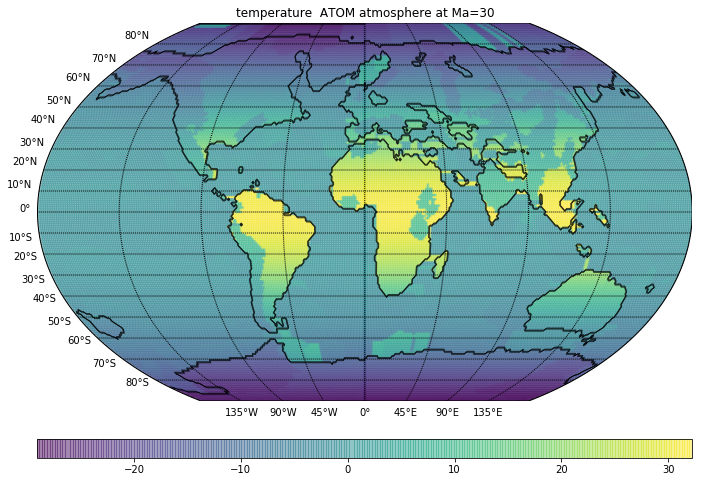

In [5]:
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
import numpy as np

def plot_xyz(topo, series, title, lats, lons):

    plt.figure(figsize=(15, 8))

    m = Basemap(llcrnrlon=-180,llcrnrlat=-90,urcrnrlon=180,urcrnrlat=90,projection='kav7', lon_0=0)

    old_lons = lons
    lons, topo = m.shiftdata(old_lons, datain = topo, lon_0=0)
    lons, series = m.shiftdata(old_lons, datain = series, lon_0=0)

    xi, yi = m(lons, lats)
    
    cs = m.scatter(xi, yi, marker='.', c=series, alpha=0.5, lw=0)

    # Add Grid Lines
    m.drawparallels(np.arange(-90., 90., 10.), labels=[1,0,0,0], fontsize=10)
    m.drawmeridians(np.arange(-180., 180., 45.), labels=[0,0,0,1], fontsize=10)

    
    if time == 0:
        m.drawcoastlines()   
        #m.barbs(xi[points], yi[points], adata[points, 4], adata[points, 3], pivot='middle', barbcolor='#333333')

    else:  
        #m.drawcoastlines()
        con_topo = m.contour( xi.reshape((361,181)), yi.reshape((361,181)), topo.reshape((361,181)),
                        colors ='k', linewidths= 0.3 )
    
    # Add Colorbar
    cbar = m.colorbar(cs, location='bottom', pad="10%")
    # cbar.set_label(tmax_units)

    # Add Title
    plt.title(title)
    #print plt.title(title)

    plt.show()
    
adata = np.loadtxt('./output-{0}/[{0}Ma_Golonka.xyz]_PlotData_Atm.xyz'.format(time), skiprows=1)
atm_header = ['lats (deg)', 'lons (deg)', 'topography', 'v-velocity (m/s)', 
              'w-velocity (m/s)', 'velocity-mag (m/s)', 'temperature (Celcius)', 
              'water_vapour (g/kg)', 'precipitation (mm/d)', 'precipitable_water (mm)']

alats = -(adata[:, 1] - 90.)
alons = adata[:, 0]
topo = adata[:, 2]
plot_xyz(topo, adata[:, 6],  'temperature  ATOM atmosphere at Ma={0}'.format(time), alats, alons)

In [ ]:
st = np.genfromtxt('../../data/SurfaceTemperature_NASA.xyz')
# columns lons, lats, temp
alats = -(adata[:, 1] - 90.)
alons = adata[:, 0]
topo = adata[:, 2]

plot_xyz(topo, series=st[:, 2], title='Surface Temperature_NASA (Celsius) at Ma=0', lons=st[:, 0], lats=st[:, 1])
plot_xyz(topo, adata[:, 6], 'ATOM atmosphere temperature (Celsius) at Ma=%s' % time, alats, alons)


In [ ]:
st = np.genfromtxt('../../data/SurfaceTemperature.xyz')
# columns lons, lats, temp
alats = -(adata[:, 1] - 90.)
alons = adata[:, 0]
topo = adata[:, 2]

plot_xyz(topo, series=st[:, 2], title='Surface Temperature_NASA (Celsius) at Ma=0', lons=st[:, 0], lats=st[:, 1])
plot_xyz(topo, adata[:, 6], 'ATOM atmosphere temperature (Celsius) at Ma=%s' % time, alats, alons)

In [1]:
import pygplates
import numpy as np
import matplotlib.pyplot as plt
from reconstruct_atom_rasters import *
from proximity_query import *
import points_spatial_tree
from sphere_tools import sampleOnSphere

def reconstruct_grid(
        time_of_existing_grid, 
        ascii_grid_file, 
        time_for_new_grid, 
        new_ascii_grid_file,
        data_dir = './data',
        buffer_degrees = 15.):

    rotation_model=pygplates.RotationModel(
        data_dir+'/Rotations/Matthews_etal_GPC_2016_410-0Ma_GK07.rot' )
    static_polygon_features = pygplates.FeatureCollection(
        data_dir+'/ContinentalPolygons/Matthews_etal_GPC_2016_ContinentalPolygons.gpmlz' )

    tmpX,tmpY = np.meshgrid(np.arange(-180.,181.,1.),np.arange(-90.,91.,1.)) 
    tmpX = tmpX.flatten()
    tmpY = tmpY.flatten()

    points,data_array = xyzfile_to_spatial_tree_of_points(ascii_grid_file)

    spatial_tree_of_uniform_recon_points = points_spatial_tree.PointsSpatialTree(points)

    ##############
    # Continents
    ##############

    # reconstruct points within continent polygons from t_n+time_step to t_n
    recon_point_lons, recon_point_lats, point_lons, point_lats = \
        reconstruct_raster_stage(
            static_polygon_features, 
            rotation_model,
            time_of_existing_grid,
            time_for_new_grid,
            points, 
            spatial_tree_of_uniform_recon_points)


    # interpolate the values from the grid at t_n onto the unreconstructed points (where we 
    # already know the point locations at t_n+time_step)
    d,l = sampleOnSphere(data_array[:,1],
                         data_array[:,0],
                         data_array[:,2],
                         np.hstack(point_lats),
                         np.hstack(point_lons),n=4)

    interp_land_temp = data_array[:,2].ravel()[l]


    ##########
    # Oceans
    ##########

    # find points that are not within, and actually not close to (defined by some buffer distance) 
    # the continent polygons at t_n. This results in a set of points far from continents at t_n,
    # but there may be some overlap with points within continents at t_n+time_step if the time step
    # is large and/or the continents are moving quickly
    pnp_test = run_grid_pnp(time_of_existing_grid,
                            points,
                            spatial_tree_of_uniform_recon_points,
                            static_polygon_features, 
                            rotation_model, 
                            np.radians(buffer_degrees))

    ocean_index = np.where(np.array(pnp_test)==0)


    ##########################
    # Merged Land and Oceans
    ##########################

    merged_lons = np.hstack((np.hstack(recon_point_lons),data_array[ocean_index,0].flatten()))
    merged_lats = np.hstack((np.hstack(recon_point_lats),data_array[ocean_index,1].flatten()))
    merged_temp = np.hstack((interp_land_temp,data_array[ocean_index,2].flatten()))

    merged_lons = ((merged_lons+180) % 360) - 180

    d,l = sampleOnSphere(merged_lats,
                         merged_lons,
                         merged_temp,
                         tmpY,
                         tmpX,n=4)

    interp_total_temp = merged_temp.ravel()[l]

    #write_xyz_file(new_ascii_grid_file, zip(tmpX, tmpY, interp_total_temp))
    data = zip(tmpX, tmpY, interp_total_temp)
    new_data = []
    
    for x in range(0,361):
        for y in range(90,-91,-1):
            if x<=180:
                new_data.append(data[361*(y+90)+x+180])
            else:
                l=list(data[361*(y+90)+x-180])
                l[0]+=360
                new_data.append(l)
            
    write_xyz_file(new_ascii_grid_file, new_data)
    print "Reconstruction done!"
    
reconstruct_grid(0,'../data/SurfaceTemperature_NASA.xyz',10,'./temp.xyz')



Reconstruct static polygons...
Find static polygons...
Group by polygons...
Reverse reconstruct points...
Sample present-day grid...
Reconstruction done!


In [ ]:
st = np.genfromtxt('./temp_1.xyz')
adata = np.loadtxt('./output-{0}/[{0}Ma_Golonka.xyz]_PlotData_Atm.xyz'.format(10), skiprows=1)
print st.shape
topo = adata[:, 2]
time=10
plot_xyz(topo, series=st[:, 2], title='Surface Temperature_NASA (Celsius) at Ma=0', lons=st[:, 0], lats=st[:, 1])



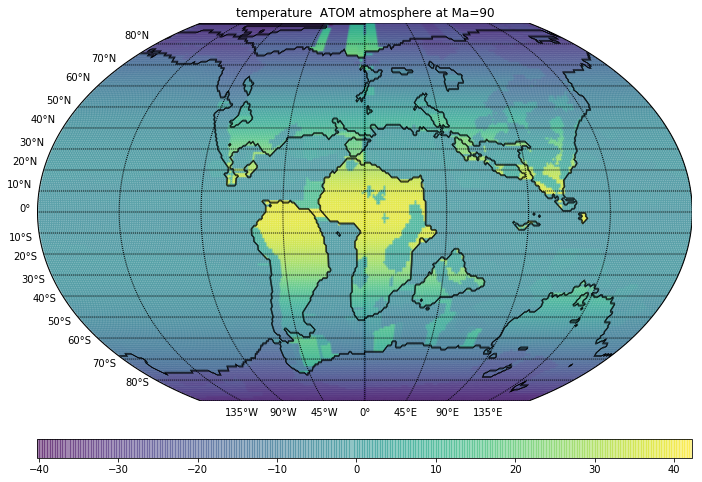

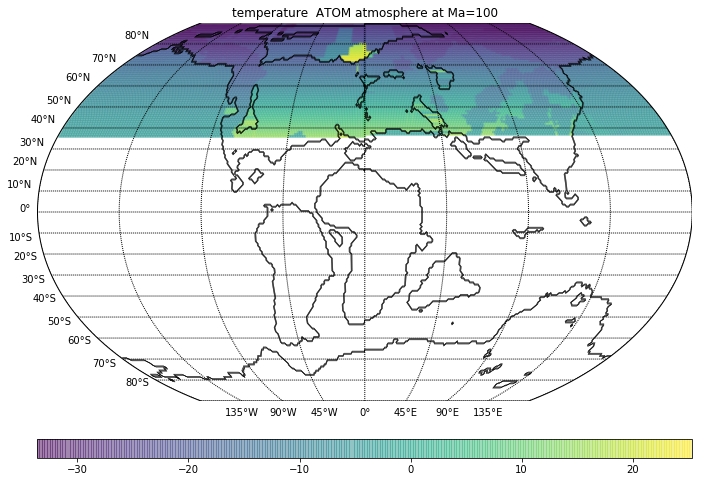

In [17]:
for t in range(90,110,10):
    adata = np.loadtxt('./output-{0}/[{0}Ma_Golonka.xyz]_PlotData_Atm.xyz'.format(t), skiprows=1)

    alats = -(adata[:, 1] - 90.)
    alons = adata[:, 0]
    topo = adata[:, 2]
    plot_xyz(topo, adata[:, 6],  'temperature  ATOM atmosphere at Ma={0}'.format(t), alats, alons)